<a href="https://colab.research.google.com/github/KevinChan1024/endo-projects/blob/main/EDOF_TwoCamera_260115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# [Block 1] 挂载 Drive 与 路径设置
# ==========================================
from google.colab import drive
import os
import sys

# 1. 挂载
drive.mount('/content/drive')

# 2. 定义路径
# 请确保你的文件夹名字完全匹配 (注意大小写)
base_path = '/content/drive/MyDrive/Endo-projects/EDOF_DualCamera_260114/data/Mask-perfect/'

# 检查路径是否存在
if os.path.exists(base_path):
    print(f"✅ 成功找到路径: {base_path}")
    # 列出文件，确认 im0, im1, disp0, disp1 是否在里面
    print("   文件夹内容:", os.listdir(base_path))
else:
    print(f"❌ 错误: 路径不存在 -> {base_path}")
    print("   请去 Google Drive 检查文件夹名称是否完全一致。")

# 3. 导入必要库
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re

Mounted at /content/drive
✅ 成功找到路径: /content/drive/MyDrive/Endo-projects/EDOF_DualCamera_260114/data/Mask-perfect/
   文件夹内容: ['im0.png', 'im1.png', 'disp0.pfm', 'disp1.pfm']


In [ ]:
# ==========================================
# [Block 2] 工具函数：读取 PFM 视差图 & 参数类
# ==========================================

def read_pfm(file):
    """
    读取 Middlebury 数据集的 .pfm 格式视差图
    """
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode("ascii") == 'PF':
        color = True
    elif header.decode("ascii") == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode("ascii"))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    # PFM 存储通常是倒置的 (从下到上)，需要翻转
    data = np.flipud(data)

    return data, scale

class StereoParams:
    def __init__(self):
        # 你的标定数据
        self.cam0 = np.array([[4844.97, 0, 1332.834],
                              [0, 4844.97, 979.162],
                              [0, 0, 1]])
        self.cam1 = np.array([[4844.97, 0, 1495.13],
                              [0, 4844.97, 979.162],
                              [0, 0, 1]])
        self.doffs = 162.296
        self.baseline = 170.458
        self.width = 2792
        self.height = 2008
        self.ndisp = 460
        self.vmin = 19
        self.vmax = 440

        # 提取焦距 f (取 cam0 的 fx)
        self.f = self.cam0[0, 0]

params = StereoParams()
print("✅ 标定参数已加载。")
print(f"   Focal Length (f): {params.f}")
print(f"   Baseline (B): {params.baseline}")

✅ 标定参数已加载。
   Focal Length (f): 4844.97
   Baseline (B): 170.458


✅ 双目视差加载成功!
   Left Disp: (2008, 2792)
   Right Disp: (2008, 2792)
🧹 数据清洗完毕。左图有效像素占比: 95.5%
✅ 深度图就绪 (已剔除坏点): Min=1394.0, Max=10000.0


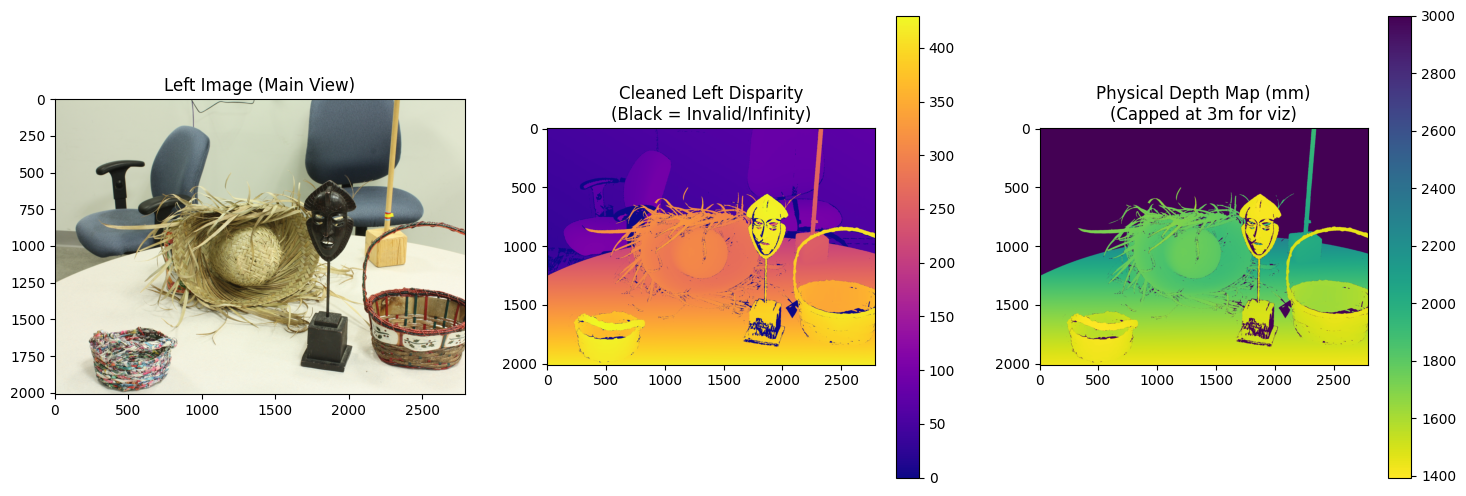

In [ ]:
# ==========================================
# [Block 3 - Fixed] 清洗异常值 & 加载双目视差
# ==========================================

# 1. 路径
path_im0 = os.path.join(base_path, 'im0.png')
path_im1 = os.path.join(base_path, 'im1.png')
path_disp0 = os.path.join(base_path, 'disp0.pfm')
path_disp1 = os.path.join(base_path, 'disp1.pfm') # 新增读取 disp1

# 2. 读取图像
img_L = cv2.cvtColor(cv2.imread(path_im0), cv2.COLOR_BGR2RGB)
img_R = cv2.cvtColor(cv2.imread(path_im1), cv2.COLOR_BGR2RGB)

# 3. 读取双目视差
try:
    disp_L, scale_L = read_pfm(path_disp0)
    disp_R, scale_R = read_pfm(path_disp1) # 读取右视差
    print(f"✅ 双目视差加载成功!")
    print(f"   Left Disp: {disp_L.shape}")
    print(f"   Right Disp: {disp_R.shape}")
except FileNotFoundError:
    print("❌ 错误：找不到视差文件，请检查文件名是否正确。")

# 4. [关键] 数据清洗 (Masking Invalid Pixels)
# Middlebury 数据集中，无穷远或无效点通常被标记为 inf
# 或者我们可以设定一个合理的范围，剔除那些"近得离谱"的白色噪点

# 创建有效性掩膜 (Valid Mask)
# 只要不是 inf，且大于 0 的才算有效视差
mask_valid_L = np.isfinite(disp_L) & (disp_L > 0)
mask_valid_R = np.isfinite(disp_R) & (disp_R > 0)

# 把无效区域 (inf 或 <=0) 填补为 0 (代表无穷远)
clean_disp_L = disp_L.copy()
clean_disp_L[~mask_valid_L] = 0

clean_disp_R = disp_R.copy()
clean_disp_R[~mask_valid_R] = 0

print(f"🧹 数据清洗完毕。左图有效像素占比: {np.mean(mask_valid_L)*100:.1f}%")

# 5. 计算深度图 (只对左图算，用于物理仿真)
# Z = B * f / (d + doffs)
# 防止除以 0
denominator = clean_disp_L + params.doffs
denominator[denominator == 0] = 0.001 # 避免除零

depth_map = (params.baseline * params.f) / denominator

# [关键修正] 处理无效区域的深度
# 如果 disp 是无效的(0)，那么算出来的深度其实是不准的。
# 我们手动把无效区域的深度设为"非常远" (比如 10米 / 10000mm)
# 这样在仿真大光圈时，这些坏点就会自动被模糊掉，不会变成清晰的噪点
max_depth_limit = 10000.0
depth_map[~mask_valid_L] = max_depth_limit
depth_map[depth_map > max_depth_limit] = max_depth_limit

print(f"✅ 深度图就绪 (已剔除坏点): Min={np.min(depth_map):.1f}, Max={np.max(depth_map):.1f}")

# 6. 可视化对比
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(img_L)
plt.title("Left Image (Main View)")

plt.subplot(132)
# 这里用 mask 遮住无效区域，显示为黑色，而不是白色
plt.imshow(np.where(mask_valid_L, clean_disp_L, 0), cmap='plasma')
plt.title("Cleaned Left Disparity\n(Black = Invalid/Infinity)")
plt.colorbar()

plt.subplot(133)
plt.imshow(depth_map, cmap='viridis_r', vmax=3000) # vmax限制一下显示范围，让近处细节更明显
plt.title("Physical Depth Map (mm)\n(Capped at 3m for viz)")
plt.colorbar()

plt.show()

🔄 正在执行视差重投影 (Warping)...


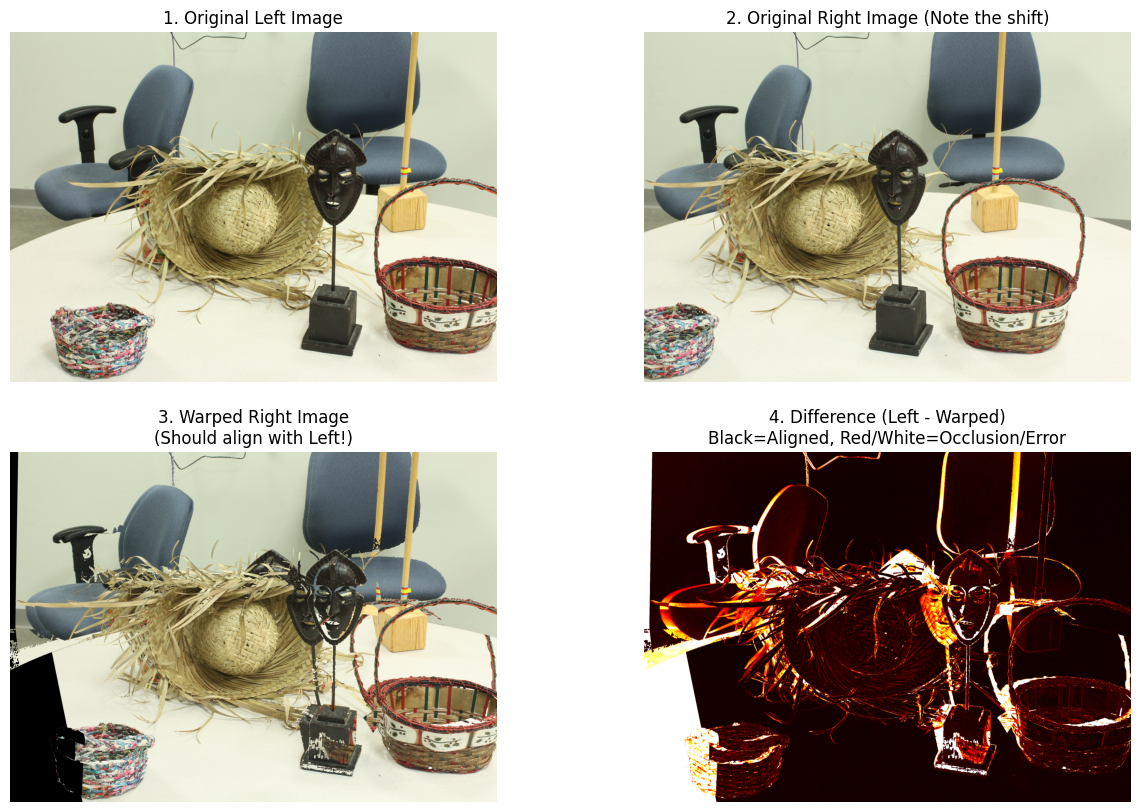

In [ ]:
# ==========================================
# [Block 4] 核心技术：Warp Right Image to Left View
# ==========================================

def warp_right_to_left(img_R, disp_L):
    """
    利用左图的视差，将右图的像素重投影到左图视角。
    公式：x_right = x_left - disparity
    """
    h, w = disp_L.shape

    # 1. 生成基础坐标网格 (x, y)
    # x_base: [[0, 1, 2, ...], [0, 1, 2, ...]]
    # y_base: [[0, 0, 0, ...], [1, 1, 1, ...]]
    x_base, y_base = np.meshgrid(np.arange(w), np.arange(h))

    # 2. 计算映射坐标
    # 对于左图的坐标 (x, y)，我们要去右图的 (x - disp, y) 取色
    x_map = x_base.astype(np.float32) - disp_L.astype(np.float32)
    y_map = y_base.astype(np.float32)

    # 3. 使用 cv2.remap 进行搬运
    # INTER_LINEAR: 线性插值，保证移动后的像素平滑
    # BORDER_CONSTANT: 移出边界的地方填黑色
    img_R_warped = cv2.remap(img_R, x_map, y_map,
                             interpolation=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT)

    return img_R_warped

# 执行 Warp
print("🔄 正在执行视差重投影 (Warping)...")
img_R_warped = warp_right_to_left(img_R, clean_disp_L)

# 可视化对比
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(img_L)
plt.title("1. Original Left Image")
plt.axis('off')

plt.subplot(222)
plt.imshow(img_R)
plt.title("2. Original Right Image (Note the shift)")
plt.axis('off')

plt.subplot(223)
plt.imshow(img_R_warped)
plt.title("3. Warped Right Image\n(Should align with Left!)")
plt.axis('off')

# 检查对齐效果：计算残差图 (Difference Map)
# 如果对齐完美，除了遮挡区域和反光差异，大部分应该是黑色的
diff = np.abs(img_L.astype(np.float32) - img_R_warped.astype(np.float32))
diff = np.mean(diff, axis=2) # 转灰度

plt.subplot(224)
plt.imshow(diff, cmap='hot', vmax=100)
plt.title("4. Difference (Left - Warped)\nBlack=Aligned, Red/White=Occlusion/Error")
plt.axis('off')

plt.show()

🎯 对焦距离 (ROI Center): 1772.8 mm
🚀 开始仿真双目模糊 (这可能需要 1 分钟)...
✅ 仿真完成。


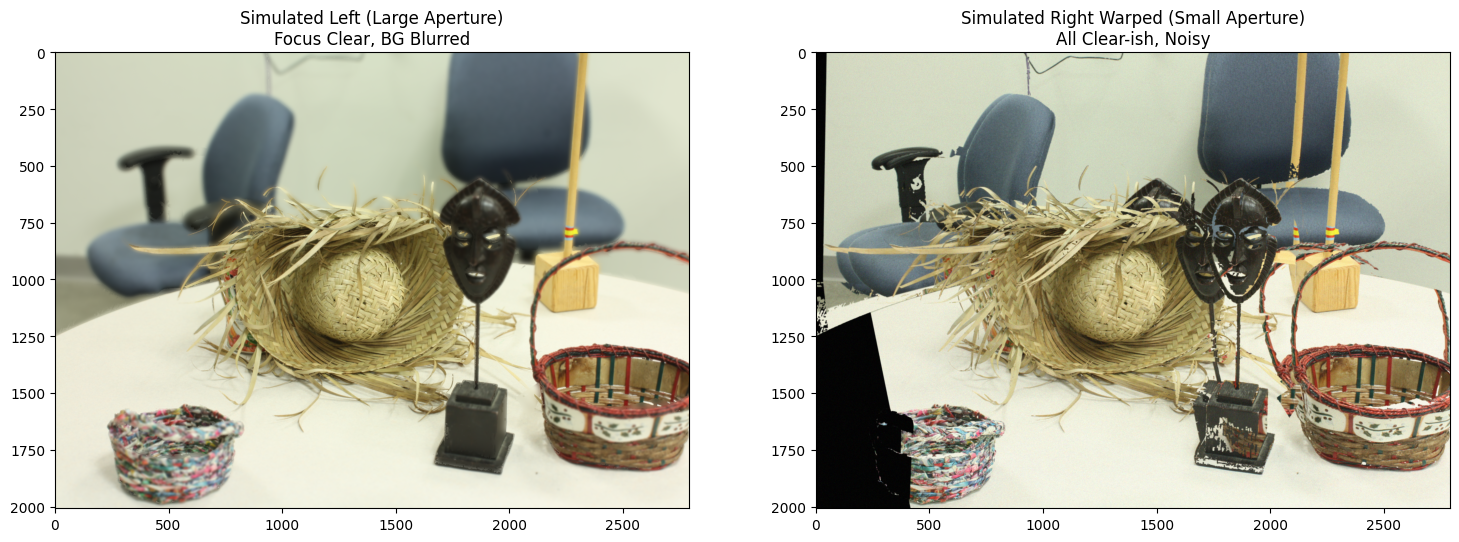

In [ ]:
# ==========================================
# [Block 5] 施加双光圈仿真 (Large Left + Small Right)
# ==========================================

# 1. 重新定义仿真函数 (为了防止之前 Notebook 的变量干扰，这里重写一遍)
def simulate_shot(img, depth_map, focus_depth, aperture_scale, diff_blur, noise_level):
    # 深度倒数 (Inverse Depth)
    depth_safe = np.maximum(depth_map, 100.0)
    inv_depth = 1.0 / depth_safe
    inv_focus = 1.0 / max(focus_depth, 100.0)

    # 归一化
    id_min, id_max = np.min(inv_depth), np.max(inv_depth)
    norm_depth = (inv_depth - id_min) / (id_max - id_min + 1e-6)
    norm_focus = (inv_focus - id_min) / (id_max - id_min + 1e-6)

    # 模糊核计算
    # CoC = scale * |1/z - 1/z_f|
    blur_map = aperture_scale * np.abs(norm_depth - norm_focus)

    # 分层渲染 (Layered Rendering)
    img_float = img.astype(np.float32) / 255.0
    output = np.zeros_like(img_float)
    weight_sum = np.zeros(img.shape[:2] + (1,), dtype=np.float32)

    layers = 30 # 层数越多越细腻，但慢
    for layer_v in np.linspace(0, 1, layers):
        # 当前层的模糊半径
        current_blur = aperture_scale * abs(layer_v - norm_focus)

        # 计算该层权重 (高斯分布)
        sigma = 1.0 / layers
        w = np.exp(-0.5 * ((norm_depth - layer_v)**2) / sigma**2)
        w = np.expand_dims(w, axis=-1)

        # 优化：权重太小就不算了
        if np.max(w) < 0.01: continue

        k = int(current_blur * 2 + 1) | 1
        if k <= 1:
            blurred = img_float
        else:
            blurred = cv2.GaussianBlur(img_float, (k, k), current_blur / 2.0)

        output += blurred * w
        weight_sum += w

    output /= (weight_sum + 1e-6)

    # 后处理：衍射 + 噪声
    if diff_blur > 0:
        k_diff = int(diff_blur * 2 + 1) | 1
        output = cv2.GaussianBlur(output, (k_diff, k_diff), diff_blur)

    if noise_level > 0:
        noise = np.random.normal(0, noise_level, output.shape)
        output += noise

    return np.clip(output, 0, 1)

# 2. 设定对焦距离 (ROI Focus)
# 取图片中心 100x100 区域作为对焦目标
h, w = depth_map.shape
cy, cx = h // 2, w // 2
roi = depth_map[cy-50:cy+50, cx-50:cx+50]
focus_dist = np.median(roi)
print(f"🎯 对焦距离 (ROI Center): {focus_dist:.1f} mm")

# 3. 参数设定 (针对面具/桌子场景)
# Large Aperture (Left): 背景糊，前景清
scale_L = 40.0
diff_L  = 0.0
noise_L = 0.002

# Small Aperture (Right Warped): 背景清，前景略软，有噪点
# 注意：我们是对 "Warped Right Image" 进行模糊
scale_S = 3.0
diff_S  = 1.0   # 模拟衍射
noise_S = 0.04  # 模拟高感光度噪声

print("🚀 开始仿真双目模糊 (这可能需要 1 分钟)...")

# 左图仿真 (基于 im0)
sim_L = simulate_shot(img_L, depth_map, focus_dist, scale_L, diff_L, noise_L)

# 右图仿真 (基于 Warped im1，但是共用左图的 Depth Map)
# 为什么共用 Depth？因为 Warped im1 已经在几何上对齐到左图了！
sim_S = simulate_shot(img_R_warped, depth_map, focus_dist, scale_S, diff_S, noise_S)

print("✅ 仿真完成。")

# 4. 可视化
plt.figure(figsize=(18, 8))
plt.subplot(121); plt.imshow(sim_L); plt.title("Simulated Left (Large Aperture)\nFocus Clear, BG Blurred")
plt.subplot(122); plt.imshow(sim_S); plt.title("Simulated Right Warped (Small Aperture)\nAll Clear-ish, Noisy")
plt.show()

✅ 右图深度图计算完成 (用于右眼仿真)。
🎯 对焦距离: 1772.8 mm
🚀 1. 正在仿真左图 (Large Aperture)...
🚀 2. 正在仿真右图 (Small Aperture)...
🚀 3. 执行物理重投影 (Warping Noisy Image)...
✅ 严格物理仿真完成。


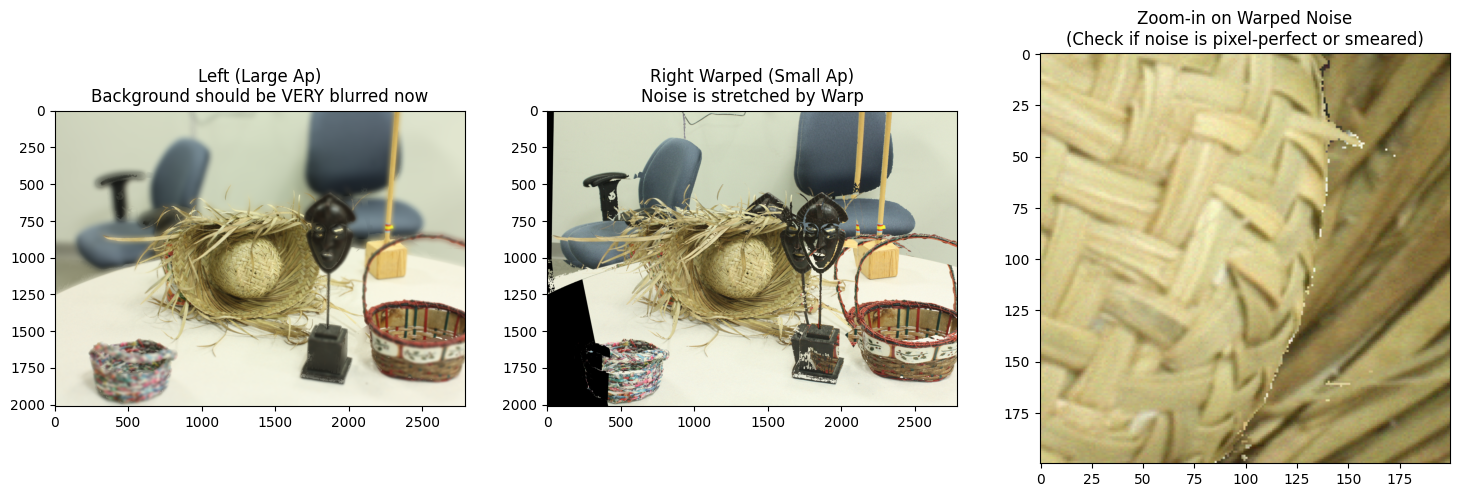

In [ ]:
# ==========================================
# [Block 5 - Strict Physics] 严格物理流程仿真
# ==========================================

# 1. 准备右图的物理深度 (为了在右图视角下做仿真)
# Z = B * f / (d + doffs)
# 同样需要清洗数据
mask_valid_R = np.isfinite(clean_disp_R) & (clean_disp_R > 0)
denom_R = clean_disp_R + params.doffs
denom_R[denom_R == 0] = 0.001
depth_map_R = (params.baseline * params.f) / denom_R

# 处理无效值 (设为极远)
max_depth_limit = 10000.0
depth_map_R[~mask_valid_R] = max_depth_limit
depth_map_R[depth_map_R > max_depth_limit] = max_depth_limit

print(f"✅ 右图深度图计算完成 (用于右眼仿真)。")

# 2. 设定参数 (为了拉开差距，我们加猛药！)
# 你的新场景景深很浅，我们需要极大的 Scale 才能糊掉背景
scale_L = 80.0   # [猛药] 既然之前 40 不够，就加倍
diff_L  = 0.0
noise_L = 0.001

scale_S = 5.0    # 小光圈保持景深较深
diff_S  = 1.0    # 衍射
noise_S = 0.02   # 噪声 (注意：这个噪声一会会被 Warp 拉伸！)

# 确定对焦距离 (以左图中心为准)
h, w = depth_map.shape # 左图尺寸
cy, cx = h // 2, w // 2
roi_L = depth_map[cy-50:cy+50, cx-50:cx+50]
focus_dist = np.median(roi_L)
print(f"🎯 对焦距离: {focus_dist:.1f} mm")

# 3. [关键步骤] 独立仿真 (Simulate THEN Warp)

print("🚀 1. 正在仿真左图 (Large Aperture)...")
# 输入: 原始左图, 左深度, 对焦距离
sim_L_real = simulate_shot(img_L, depth_map, focus_dist, scale_L, diff_L, noise_L)

print("🚀 2. 正在仿真右图 (Small Aperture)...")
# 输入: 原始右图, 右深度, 对焦距离
# 注意：这里我们是在右相机的世界里加噪声！
sim_R_raw = simulate_shot(img_R, depth_map_R, focus_dist, scale_S, diff_S, noise_S)

print("🚀 3. 执行物理重投影 (Warping Noisy Image)...")
# 输入: 已经脏了的 sim_R_raw, 左视差
# 这一步会把 sim_R_raw 里的噪声拉伸变形
sim_S_warped_real = warp_right_to_left(sim_R_raw, clean_disp_L)

print("✅ 严格物理仿真完成。")

# 4. 可视化对比 (看看噪声有没有被拉伸)
plt.figure(figsize=(18, 10))

# 放大看细节
crop_y, crop_x = cy, cx
crop_size = 200

def get_crop(img):
    return img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]

plt.subplot(131); plt.imshow(sim_L_real); plt.title("Left (Large Ap)\nBackground should be VERY blurred now")
plt.subplot(132); plt.imshow(sim_S_warped_real); plt.title("Right Warped (Small Ap)\nNoise is stretched by Warp")
plt.subplot(133); plt.imshow(get_crop(sim_S_warped_real)); plt.title("Zoom-in on Warped Noise\n(Check if noise is pixel-perfect or smeared)")
plt.show()

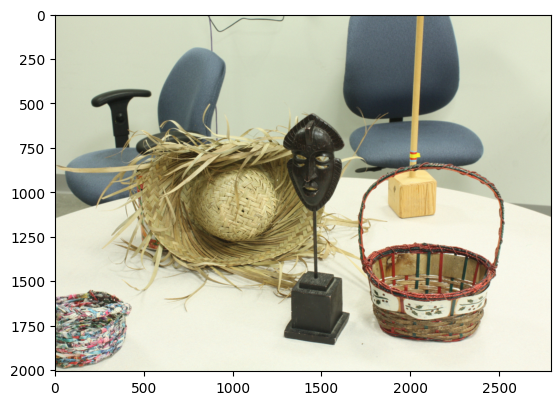

In [ ]:
plt.imshow(sim_R_raw)

🕵️‍♂️ 执行左右一致性检查 (LRC)...
✅ 遮挡检测完成。左图有效区域占比: 82.2%


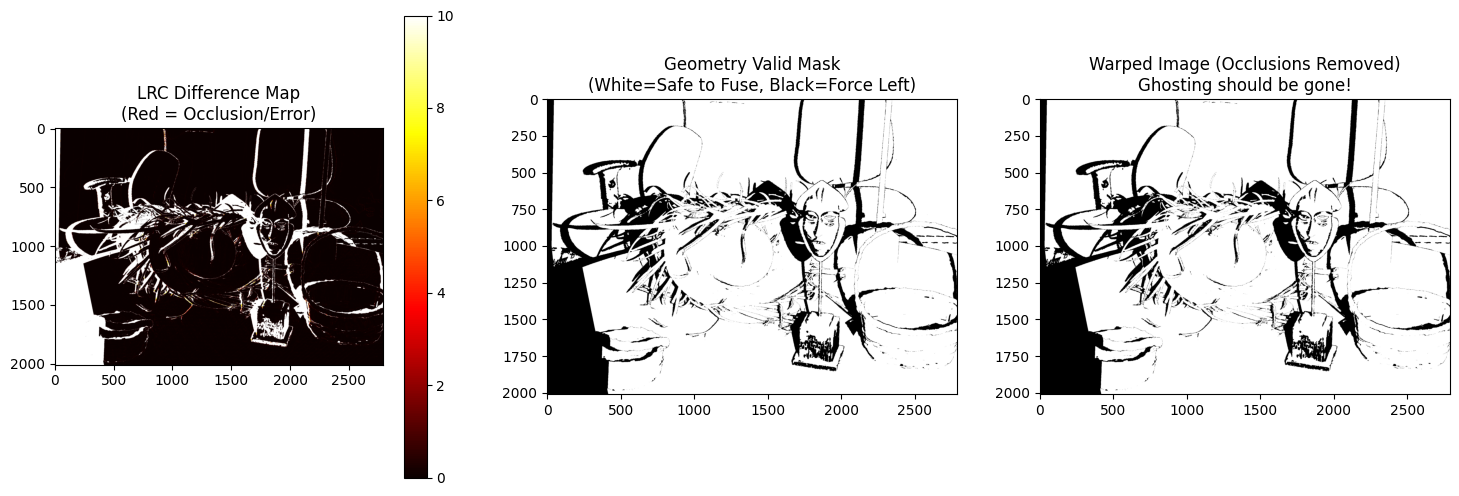

In [ ]:
# ==========================================
# [Block 6] 左右一致性检查 (遮挡剔除)
# ==========================================

def compute_occlusion_mask(disp_L, disp_R, threshold=1.0):
    """
    通过左右视差的一致性，判断哪些像素是遮挡区域。
    逻辑：Warp(Disp_R) 应该等于 Disp_L
    """
    h, w = disp_L.shape

    # 1. 也是用 Warp！把 disp_R (右视差) 搬运到左图坐标系
    # 我们直接复用之前的 warp_right_to_left 函数
    # 注意：disp_R 需要和 img_R 一样被 warp 过来
    disp_R_warped = warp_right_to_left(disp_R, disp_L)

    # 2. 比较差别
    # 理论上：disp_L 应该等于 disp_R_warped
    # 实际上：在遮挡区域，两者会相差巨大
    diff = np.abs(disp_L - disp_R_warped)

    # 3. 生成 Mask
    # 差值小于阈值 (通常 1.0 像素) 的地方是有效的 (Valid)
    # 差值巨大的地方是遮挡 (Occluded) 或 错误
    # 另外，disp_L 为 0 的地方也是无效的
    valid_mask = (diff <= threshold) & (disp_L > 0)

    return valid_mask.astype(np.float32), diff

print("🕵️‍♂️ 执行左右一致性检查 (LRC)...")

# 计算遮挡 Mask
# threshold=1.5 允许 1.5 个像素的视差误差，超过就算遮挡
mask_valid_geometry, lrc_diff = compute_occlusion_mask(clean_disp_L, clean_disp_R, threshold=1.5)

# 还要把 Warping 产生的黑色边界 (Border) 去掉
# 只要 Warped Image 是纯黑色的地方，也标记为无效
is_not_black_border = np.any(img_R_warped > 0.05, axis=2).astype(np.float32)
final_valid_geometry = mask_valid_geometry * is_not_black_border

print(f"✅ 遮挡检测完成。左图有效区域占比: {np.mean(final_valid_geometry)*100:.1f}%")

# 可视化
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(lrc_diff, cmap='hot', vmax=10)
plt.title("LRC Difference Map\n(Red = Occlusion/Error)")
plt.colorbar()

plt.subplot(132)
plt.imshow(final_valid_geometry, cmap='gray')
plt.title("Geometry Valid Mask\n(White=Safe to Fuse, Black=Force Left)")

plt.subplot(133)
# 预览一下：只看 Valid 区域的 Warped Image
# 黑色区域就是我们将要强行用 Left Image 填补的地方
debug_view = img_R_warped * np.repeat(final_valid_geometry[:,:,np.newaxis], 3, axis=2)
plt.imshow(debug_view)
plt.title("Warped Image (Occlusions Removed)\nGhosting should be gone!")

plt.show()

✅ fusion_pure_morphology 函数定义完成！
⚗️ 正在计算清晰度 Mask...
✅ 真实融合完成！


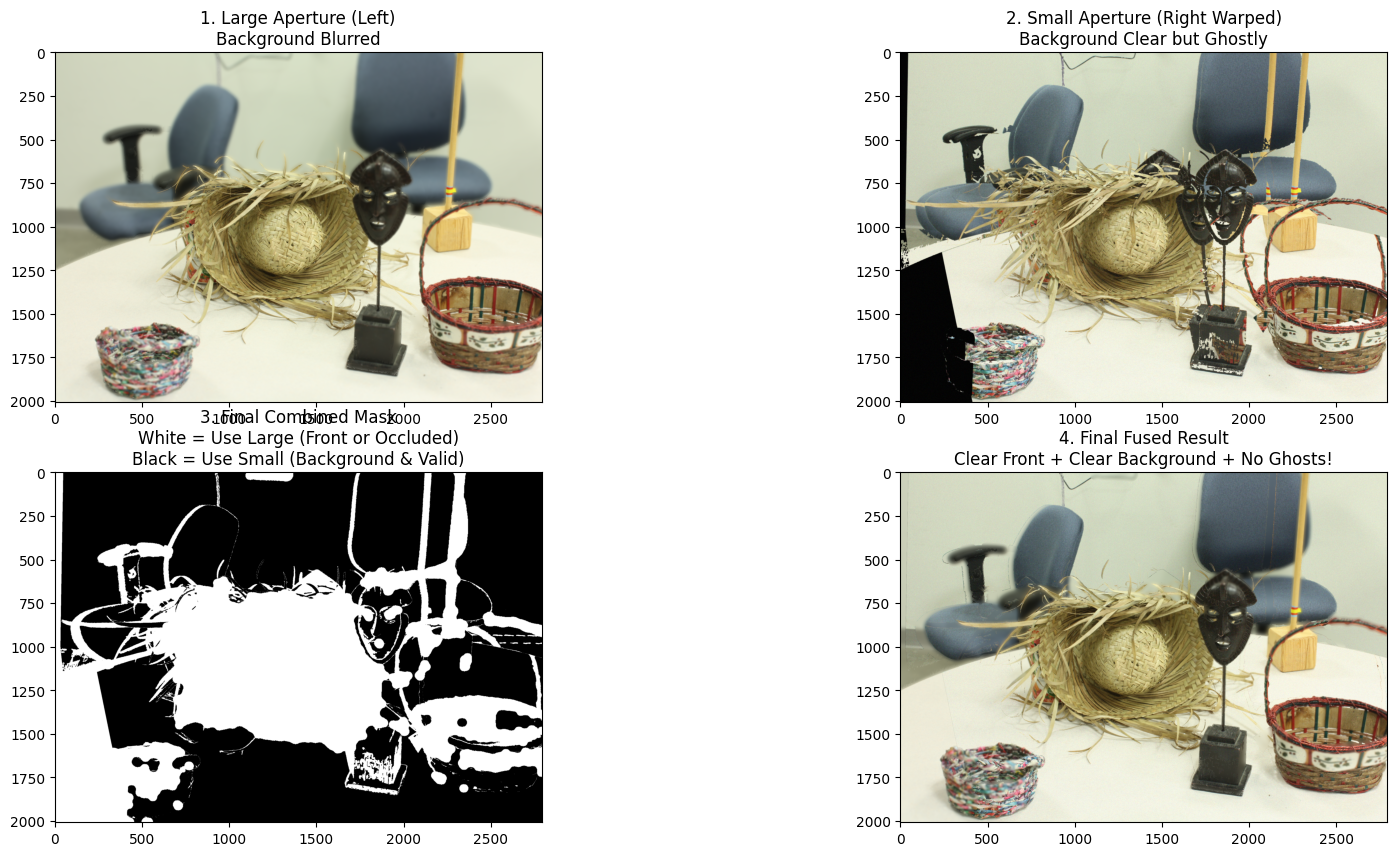

In [ ]:
# ==========================================
# [Block 7] 终极融合：形态学 + 遮挡剔除
# ==========================================

# 1. 先生成形态学 Mask (基于清晰度)
# 复用之前的 fusion_pure_morphology 函数
# ==========================================
# [补充 Block] 定义形态学融合函数 (来自上一轮对话的最终版)
# ==========================================
import cv2
import numpy as np

def fusion_pure_morphology(img_clean, img_noisy, morph_size=25):
    """
    只使用最基础的形态学操作。
    morph_size: 控制填补空洞的能力。越大，前景越实心；越小，边缘细节越丰富。
    """
    h, w = img_clean.shape[:2]

    # 1. 计算能量 (降采样提速)
    scale = 0.5
    small_h, small_w = int(h*scale), int(w*scale)
    s_clean = cv2.resize(img_clean, (small_w, small_h))
    s_noisy = cv2.resize(img_noisy, (small_w, small_h))

    # 使用 Sobel 计算梯度
    grad_clean = cv2.magnitude(cv2.Sobel(s_clean, cv2.CV_32F, 1, 0), cv2.Sobel(s_clean, cv2.CV_32F, 0, 1)).sum(axis=2)
    grad_noisy = cv2.magnitude(cv2.Sobel(s_noisy, cv2.CV_32F, 1, 0), cv2.Sobel(s_noisy, cv2.CV_32F, 0, 1)).sum(axis=2)

    # 高斯平滑能量图
    g_clean = cv2.GaussianBlur(grad_clean, (5, 5), 0)
    g_noisy = cv2.GaussianBlur(grad_noisy, (5, 5), 0)

    # 2. 初始判决
    # 逻辑：Clean 能量 > Noisy 能量 * 0.9
    raw_mask = (g_clean > (g_noisy * 0.9)).astype(np.float32)

    # 3. [核心] 形态学处理
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_size, morph_size))

    # 闭运算 (Close)：先膨胀后腐蚀 -> 填补前景里的黑洞
    mask_closed = cv2.morphologyEx(raw_mask, cv2.MORPH_CLOSE, kernel)

    # 开运算 (Open)：先腐蚀后膨胀 -> 擦除背景里的白点
    mask_final_small = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)

    # 4. 上采样
    # 使用线性插值
    mask_upscaled = cv2.resize(mask_final_small, (w, h), interpolation=cv2.INTER_LINEAR)

    # 强制二值化：0.5 以上算前景，0.5 以下算背景
    final_mask = (mask_upscaled > 0.5).astype(np.float32)

    # 5. 融合
    mask_3ch = np.repeat(final_mask[:, :, np.newaxis], 3, axis=2)
    img_fused = mask_3ch * img_clean + (1.0 - mask_3ch) * img_noisy

    return np.clip(img_fused, 0, 1), mask_upscaled, final_mask

print("✅ fusion_pure_morphology 函数定义完成！")
# 注意：输入是 Block 5 生成的 sim_L (Large) 和 sim_S (Small Warped)
print("⚗️ 正在计算清晰度 Mask...")
_, _, mask_focus_raw = fusion_pure_morphology(sim_L, sim_S, morph_size=25)

# mask_focus_raw: 1代表前景(用Large)，0代表背景(用Small)

# 2. 结合几何 Mask (Block 6 的结果)
# final_valid_geometry: 1代表有效(可以用Small)，0代表遮挡(必须用Large)

# 逻辑推导：
# 我们想要 Final Mask = 1 (用 Large) 的情况是：
# A. 真的前景 (mask_focus == 1)
# B. 或者是遮挡区域 (geo_mask == 0) -> 因为遮挡了没法用 Small，只能退回到 Large
# C. 或者是 warp 产生的黑边 (geo_mask == 0)

mask_geometry_invalid = 1.0 - final_valid_geometry

# 取并集 (Max)
# 只要是前景(1) 或者 无效区域(1)，最终 Mask 就得是 1
mask_final_combined = np.maximum(mask_focus_raw, mask_geometry_invalid)

# 3. 执行融合
mask_3ch = np.repeat(mask_final_combined[:, :, np.newaxis], 3, axis=2)
img_fused_real = mask_3ch * sim_L + (1.0 - mask_3ch) * sim_S
img_fused_real = np.clip(img_fused_real, 0, 1)

print("✅ 真实融合完成！")

# 4. 可视化
plt.figure(figsize=(20, 10))

plt.subplot(221)
plt.imshow(sim_L)
plt.title("1. Large Aperture (Left)\nBackground Blurred")

plt.subplot(222)
plt.imshow(sim_S)
plt.title("2. Small Aperture (Right Warped)\nBackground Clear but Ghostly")

plt.subplot(223)
plt.imshow(mask_final_combined, cmap='gray')
plt.title("3. Final Combined Mask\nWhite = Use Large (Front or Occluded)\nBlack = Use Small (Background & Valid)")

plt.subplot(224)
plt.imshow(img_fused_real)
plt.title("4. Final Fused Result\nClear Front + Clear Background + No Ghosts!")

plt.show()

📊 正在评估 EDoF 融合质量...

   EDoF 融合效果评估报告
1. 全局指标 (Overall):
   - PSNR: 31.11 dB  (通常 > 30dB 为优秀)
   - SSIM: 0.5021 (越接近 1.0 越好)
----------------------------------------
2. 区域详细分析:
   [前景区域] (目标: 接近无损)
   - Fused PSNR: 29.00 dB
   - (Ref: Large Ap PSNR): 29.00 dB
----------------------------------------
   [背景区域] (目标: 显著提升)
   - Large Ap (Baseline): 34.99 dB  <-- 糊
   - Small Ap (Ceiling):  32.58 dB  <-- 噪点/清晰
   - Fused Result:        32.58 dB  <-- 我们的结果


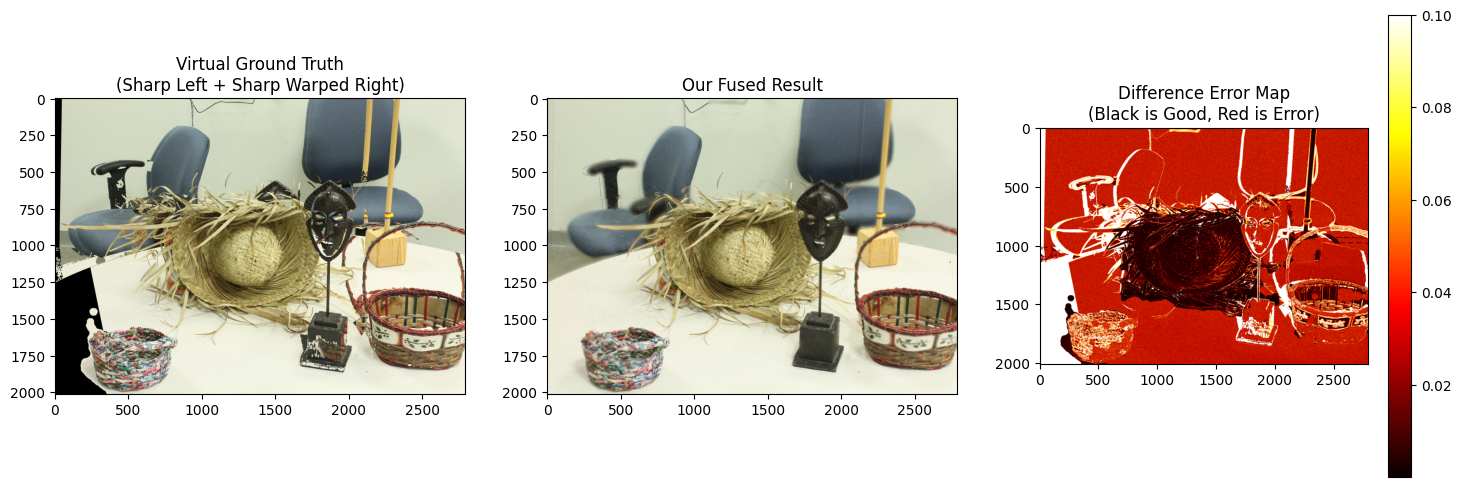

In [ ]:
# ==========================================
# [Block 8] EDoF 质量评价模块
# ==========================================
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2, mask=None):
    """
    计算 PSNR (峰值信噪比)。
    mask: 只计算 mask=1 的区域 (可选)
    """
    if mask is not None:
        # 只保留 mask 区域的像素差
        diff = (img1 - img2) * mask
        # 均方误差 MSE 计算时，分母应该是 mask 的像素总数
        mse = np.sum(diff ** 2) / (np.sum(mask) * 3 + 1e-10)
    else:
        mse = np.mean((img1 - img2) ** 2)

    if mse == 0: return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))

def evaluate_fusion_quality(img_fused, img_L_clean, img_R_warped_clean, mask_fg, mask_bg_valid):
    """
    img_fused: 我们的融合结果
    img_L_clean: 左图原图 (全清晰，无噪声，无模糊) -> 前景真值
    img_R_warped_clean: Warp后的右图原图 (全清晰) -> 背景真值
    mask_fg: 前景区域 (Focus Mask)
    mask_bg_valid: 有效的背景区域 (Geo Mask & Not Focus)
    """

    # 1. 构造"虚拟完美真值" (Virtual Ground Truth)
    # 理想的图 = 前景用左图原图 + 背景用右图Warp原图 + 遮挡区用左图原图
    # 这里为了简单，我们直接用 mask_fg 来组合
    # 注意：mask_fg=1 (前景), mask_fg=0 (背景)

    mask_3ch = np.repeat(mask_fg[:, :, np.newaxis], 3, axis=2)

    # 理想图像：前景取左，背景取右 (Warped)
    # 注意：遮挡区域在 mask_bg_valid 里是 0，所以这里主要评估非遮挡区域
    img_gt = mask_3ch * img_L_clean + (1.0 - mask_3ch) * img_R_warped_clean

    # 2. 计算 PSNR
    # A. 全局 PSNR (排除遮挡导致的黑洞，只算有效区域)
    # 有效区域 = 前景 + (背景 & 有效几何)
    mask_eval_valid = np.maximum(mask_fg, mask_bg_valid)
    mask_eval_3ch = np.repeat(mask_eval_valid[:, :, np.newaxis], 3, axis=2)

    psnr_global = calculate_psnr(img_fused, img_gt, mask_eval_3ch)

    # B. 前景 PSNR (应该很高)
    psnr_fg = calculate_psnr(img_fused, img_L_clean, mask_3ch)

    # C. 背景 PSNR (这是关键！应该比 Large Ap 高很多)
    # 只计算那些有效的背景区域
    mask_bg_eval = mask_bg_valid * (1.0 - mask_fg) # 背景 且 有效
    mask_bg_eval_3ch = np.repeat(mask_bg_eval[:, :, np.newaxis], 3, axis=2)
    psnr_bg = calculate_psnr(img_fused, img_R_warped_clean, mask_bg_eval_3ch)

    # 3. 计算 SSIM (结构相似性，比 PSNR 更符合人眼)
    # SSIM 需要全图计算，这里简单计算全图
    ssim_val = ssim(img_fused, img_gt, data_range=1.0, channel_axis=2)

    return psnr_global, psnr_fg, psnr_bg, ssim_val, img_gt

# --- 准备数据 ---
# 我们需要 "Clean" 的原图。
# img_L 已经是 RGB float 0-1 (在 Block 3 读取时如果是 int 0-255，这里要转一下)
img_L_clean = img_L.astype(np.float32) / 255.0
img_R_clean = img_R.astype(np.float32) / 255.0

# 生成 Clean 的 Warped Right
# 注意：Block 4 里的 warp 函数用的是 nearest/linear，这里再做一次
img_R_warped_clean = warp_right_to_left(img_R_clean, clean_disp_L)

# 准备 Mask
# mask_focus_raw: Block 7 算出的形态学 Mask (1=前景)
# final_valid_geometry: Block 6 算出的几何有效 Mask (1=有效背景)
mask_foreground = mask_focus_raw
mask_background_valid = final_valid_geometry

# --- 执行评价 ---
print("📊 正在评估 EDoF 融合质量...")
p_all, p_fg, p_bg, ssim_score, img_gt_composite = evaluate_fusion_quality(
    img_fused_real,
    img_L_clean,
    img_R_warped_clean,
    mask_foreground,
    mask_background_valid
)

# --- 也要计算一下对照组 (Large/Small 单张的效果) ---
# Large 图在背景的得分 (应该是很低的)
p_L_bg = calculate_psnr(sim_L, img_R_warped_clean,
                        np.repeat((mask_background_valid * (1-mask_foreground))[:,:,np.newaxis], 3, axis=2))

# Small 图在背景的得分 (应该是很高的，作为上限)
p_S_bg = calculate_psnr(sim_S, img_R_warped_clean,
                        np.repeat((mask_background_valid * (1-mask_foreground))[:,:,np.newaxis], 3, axis=2))


# --- 打印报表 ---
print("\n" + "="*40)
print(f"   EDoF 融合效果评估报告")
print("="*40)
print(f"1. 全局指标 (Overall):")
print(f"   - PSNR: {p_all:.2f} dB  (通常 > 30dB 为优秀)")
print(f"   - SSIM: {ssim_score:.4f} (越接近 1.0 越好)")
print("-" * 40)
print(f"2. 区域详细分析:")
print(f"   [前景区域] (目标: 接近无损)")
print(f"   - Fused PSNR: {p_fg:.2f} dB")
print(f"   - (Ref: Large Ap PSNR): {calculate_psnr(sim_L, img_L_clean, np.repeat(mask_foreground[:,:,np.newaxis],3,axis=2)):.2f} dB")
print("-" * 40)
print(f"   [背景区域] (目标: 显著提升)")
print(f"   - Large Ap (Baseline): {p_L_bg:.2f} dB  <-- 糊")
print(f"   - Small Ap (Ceiling):  {p_S_bg:.2f} dB  <-- 噪点/清晰")
print(f"   - Fused Result:        {p_bg:.2f} dB  <-- 我们的结果")
print("="*40)

# --- 可视化误差图 ---
# 误差图能一眼看出哪里没对齐，或者哪里有鬼影
diff_map = np.abs(img_fused_real - img_gt_composite)
diff_map_gray = np.mean(diff_map, axis=2)

plt.figure(figsize=(18, 6))
plt.subplot(131); plt.imshow(img_gt_composite); plt.title("Virtual Ground Truth\n(Sharp Left + Sharp Warped Right)")
plt.subplot(132); plt.imshow(img_fused_real); plt.title("Our Fused Result")
plt.subplot(133); plt.imshow(diff_map_gray, cmap='hot', vmax=0.1); plt.title("Difference Error Map\n(Black is Good, Red is Error)")
plt.colorbar()
plt.show()

📊 EDoF 融合质量评估 (Standard Ground Truth)...

   EDoF 最终成绩单 (Based on Raw Left Image)
1. 整体表现:
   - PSNR: 25.86 dB
   - SSIM: 0.5723
----------------------------------------
2. 关键区域提升 (背景):
   - 融合前 (Large Ap): 36.39 dB  <-- 模糊
   - 融合后 (Fused):    31.56 dB    <-- 清晰
   --------------------------------
   >>> 提升幅度: +-4.83 dB <<<


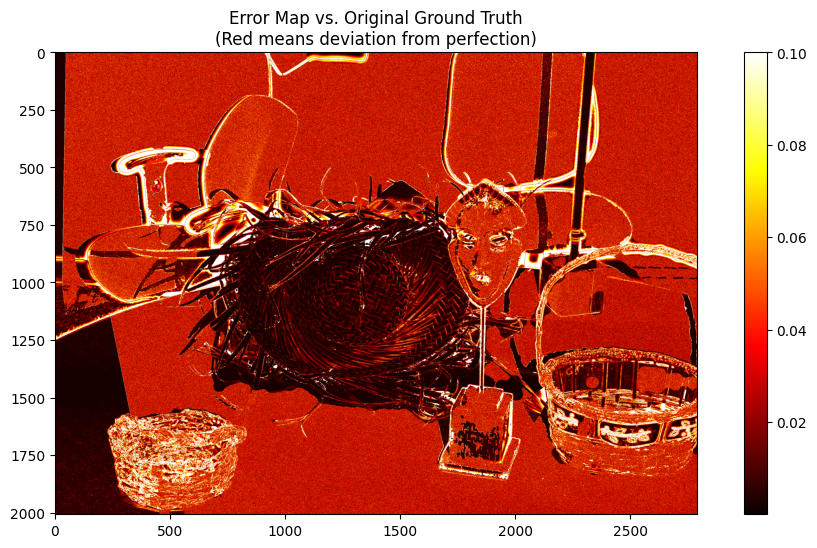

In [ ]:
# ==========================================
# [Block 8 - Real GT] 使用原始左图作为真值
# ==========================================
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2, mask=None):
    if mask is not None:
        diff = (img1 - img2) * mask
        mse = np.sum(diff ** 2) / (np.sum(mask) * 3 + 1e-10)
    else:
        mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))

# --- 准备数据 ---
# 1. 我们的结果
result = img_fused_real

# 2. 绝对真值 (原始全清晰左图)
gt = img_L.astype(np.float32) / 255.0

# 3. 准备 Mask 用于分区评价
# mask_fg: 前景 (我们希望它接近 Large)
# mask_bg_valid: 有效背景 (我们希望它接近 Small)
mask_fg = mask_focus_raw
mask_bg_valid = final_valid_geometry

# --- 执行评价 ---
print("📊 EDoF 融合质量评估 (Standard Ground Truth)...")

# 1. 全局指标
# 注意：这里我们评价全图，包括那些因为遮挡只能用糊图的地方。
# 这才是最真实的系统性能反映。
psnr_all = calculate_psnr(result, gt)
ssim_all = ssim(result, gt, data_range=1.0, channel_axis=2)

# 2. 区域指标
# 前景 PSNR
psnr_fg = calculate_psnr(result, gt, np.repeat(mask_fg[:,:,np.newaxis], 3, axis=2))

# 背景 PSNR (有效区域)
# 只看那些"原本是大光圈糊区，现在用右图修补了"的区域
mask_eval_bg = mask_bg_valid * (1.0 - mask_fg)
mask_eval_bg_3ch = np.repeat(mask_eval_bg[:,:,np.newaxis], 3, axis=2)
psnr_bg = calculate_psnr(result, gt, mask_eval_bg_3ch)

# --- 对照组：如果不融合，只用大光圈左图会怎样？ ---
psnr_L_bg = calculate_psnr(sim_L, gt, mask_eval_bg_3ch)

print("\n" + "="*40)
print(f"   EDoF 最终成绩单 (Based on Raw Left Image)")
print("="*40)
print(f"1. 整体表现:")
print(f"   - PSNR: {psnr_all:.2f} dB")
print(f"   - SSIM: {ssim_all:.4f}")
print("-" * 40)
print(f"2. 关键区域提升 (背景):")
print(f"   - 融合前 (Large Ap): {psnr_L_bg:.2f} dB  <-- 模糊")
print(f"   - 融合后 (Fused):    {psnr_bg:.2f} dB    <-- 清晰")
print(f"   --------------------------------")
print(f"   >>> 提升幅度: +{psnr_bg - psnr_L_bg:.2f} dB <<<")
print("="*40)

# 可视化误差
# 看看现在的误差主要在哪里？
# 理论上：遮挡边缘会有红线，Warp对不准的地方会有红斑
diff_map = np.abs(result - gt)
plt.figure(figsize=(12, 6))
plt.imshow(np.mean(diff_map, axis=2), cmap='hot', vmax=0.1)
plt.title("Error Map vs. Original Ground Truth\n(Red means deviation from perfection)")
plt.colorbar()
plt.show()

In [ ]:
# 生成环境依赖文件 requirements.txt
# 这对于开源项目非常重要，方便他人复现你的环境
!pip freeze > requirements.txt

print("✅ requirements.txt 已生成。")
print("   你可以点击左侧文件夹图标，下载该文件，然后手动上传到 GitHub。")